<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_5_tabular_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applications of Deep Neural Networks
**Generative Adversarial Networks**


In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# HIDE OUTPUT
CMD = "wget https://raw.githubusercontent.com/Diyago/"\
  "GAN-for-tabular-data/master/requirements.txt"

!{CMD}
!pip install -r requirements.txt
!pip install tabgan

--2023-02-22 15:11:43--  https://raw.githubusercontent.com/Diyago/GAN-for-tabular-data/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183 [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]     183  --.-KB/s    in 0s      

2023-02-22 15:11:43 (7.17 MB/s) - ‘requirements.txt.1’ saved [183/183]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# HIDE OUTPUT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import io
import os
import requests
import seaborn as sns
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_curve,confusion_matrix


In [4]:
fakeacc_path='/content/fakeAccountData.json'
realacc_path='/content/realAccountData.json'

with open(fakeacc_path,'r') as f:
  fake_acc_json=json.load(f)

fake_df=pd.json_normalize(fake_acc_json)

with open(realacc_path,'r') as f:
  real_acc_json=json.load(f)

real_df=pd.json_normalize(real_acc_json)

real_df.shape,fake_df.shape


((994, 9), (200, 9))

In [5]:
list_of_df=[real_df,fake_df]

df=pd.concat(list_of_df)
df=df.reset_index(drop=True)
df

,userFollowerCount,userFollowingCount,userBiographyLength,userMediaCount,userHasProfilPic,userIsPrivate,usernameDigitCount,usernameLength,isFake
0,258,238,0,0,1,0,0,10,0
1,263,482,30,29,1,1,0,8,0
2,51,78,9,0,1,1,0,10,0
3,297,480,22,25,1,1,2,9,0
4,113,242,0,95,1,1,0,10,0
...,...,...,...,...,...,...,...,...,...
1189,0,25,138,6,1,0,0,10,1
1190,0,0,52,6,1,0,3,7,1
1191,0,1,92,9,1,0,1,15,1
1192,1,0,60,5,1,0,1,13,1


In [6]:
df.isnull().sum()

userFollowerCount      0
userFollowingCount     0
userBiographyLength    0
userMediaCount         0
userHasProfilPic       0
userIsPrivate          0
usernameDigitCount     0
usernameLength         0
isFake                 0
dtype: int64

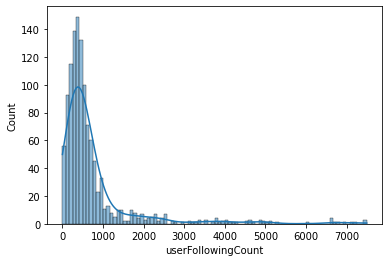

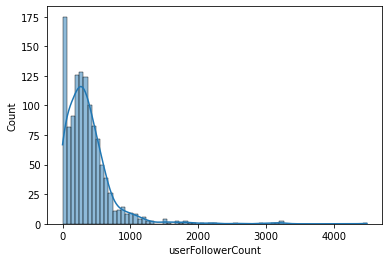

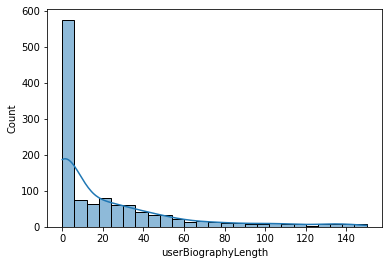

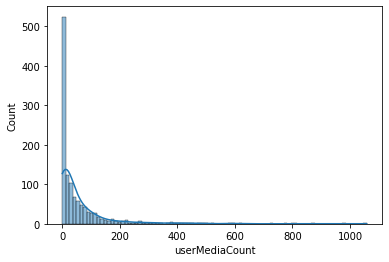

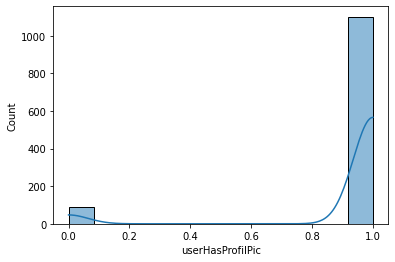

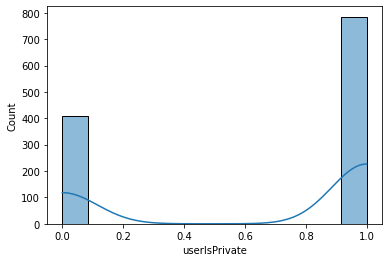

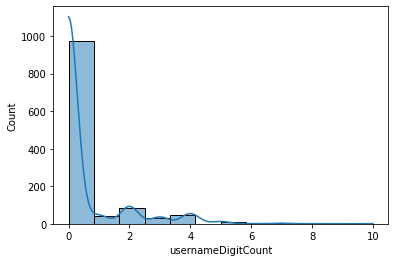

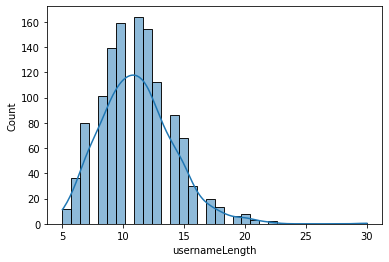

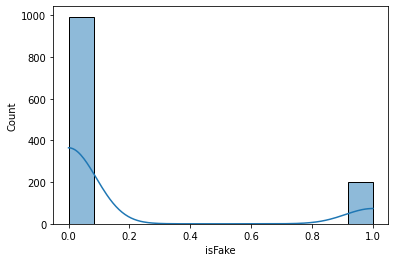

In [7]:
fig=plt.figure()
for num,i in enumerate(list(df.columns)):
  plt.figure(num)
  sns.histplot(data=df,x=i,kde=True)

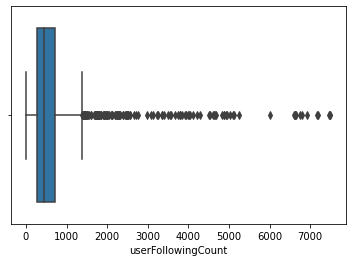

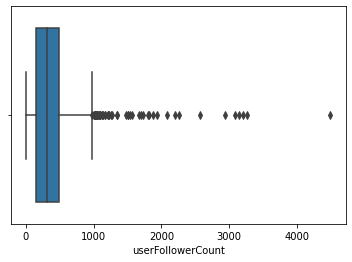

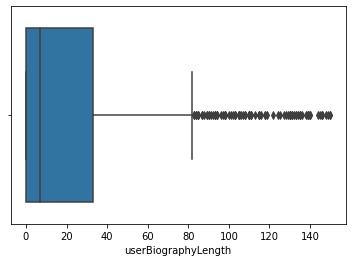

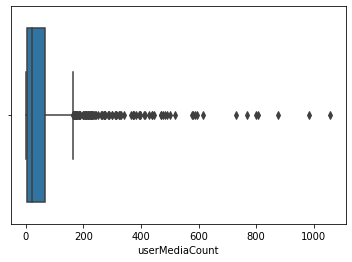

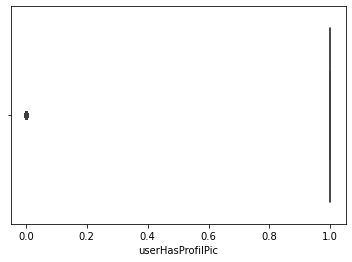

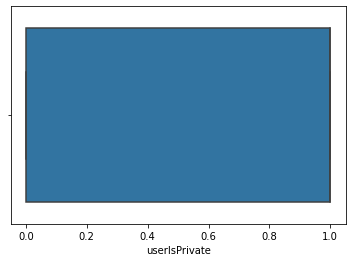

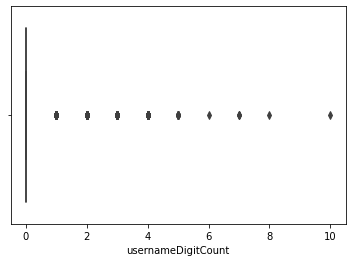

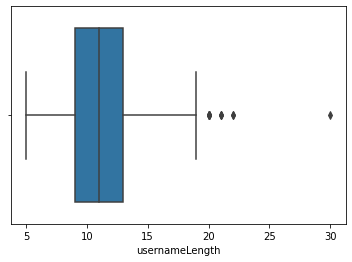

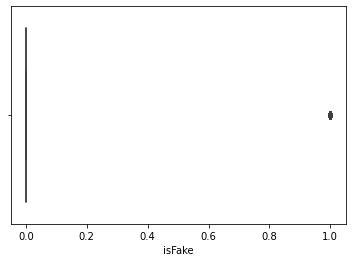

In [8]:
#boxplot
fig=plt.figure()
for num,i in enumerate(list(df.columns)):
  plt.figure(num)
  sns.boxplot(data=df,x=i)


In [9]:
df.columns

Index(['userFollowerCount', 'userFollowingCount', 'userBiographyLength',
       'userMediaCount', 'userHasProfilPic', 'userIsPrivate',
       'usernameDigitCount', 'usernameLength', 'isFake'],
      dtype='object')

In [10]:
x=df.iloc[:,:-1]
y=df['isFake']
sm=SMOTE()
xtrain,ytrain=sm.fit_resample(x,y)

In [11]:
# Split into training and test sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    xtrain,
    ytrain,
    test_size=0.20,
    #shuffle=False,
    random_state=42,
)

# Create dataframe versions for tabular GAN
df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
  df_y_test.reset_index(drop=True)
df_y_train = pd.DataFrame(df_y_train)
df_y_test = pd.DataFrame(df_y_test)

# Pandas to Numpy
x_train = df_x_train.values
x_test = df_x_test.values
y_train = df_y_train.values
y_test = df_y_test.values

# Build the neural network
model = Sequential()
# Hidden 1
model.add(Dense(50, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(12, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
        callbacks=[monitor], verbose=2,epochs=1000)

Epoch 1/1000
50/50 - 2s - loss: 7323.7476 - val_loss: 236.1751 - 2s/epoch - 37ms/step
Epoch 2/1000
50/50 - 0s - loss: 60.2916 - val_loss: 21.6668 - 192ms/epoch - 4ms/step
Epoch 3/1000
50/50 - 0s - loss: 17.7864 - val_loss: 12.0653 - 185ms/epoch - 4ms/step
Epoch 4/1000
50/50 - 0s - loss: 10.7494 - val_loss: 8.2113 - 236ms/epoch - 5ms/step
Epoch 5/1000
50/50 - 0s - loss: 7.4748 - val_loss: 6.5501 - 238ms/epoch - 5ms/step
Epoch 6/1000
50/50 - 0s - loss: 5.6226 - val_loss: 5.0038 - 289ms/epoch - 6ms/step
Epoch 7/1000
50/50 - 0s - loss: 3.8302 - val_loss: 3.7001 - 300ms/epoch - 6ms/step
Epoch 8/1000
50/50 - 0s - loss: 2.9203 - val_loss: 2.7103 - 272ms/epoch - 5ms/step
Epoch 9/1000
50/50 - 0s - loss: 1.8535 - val_loss: 2.0443 - 246ms/epoch - 5ms/step
Epoch 10/1000
50/50 - 0s - loss: 1.4593 - val_loss: 1.8599 - 293ms/epoch - 6ms/step
Epoch 11/1000
50/50 - 0s - loss: 1.3085 - val_loss: 1.6002 - 215ms/epoch - 4ms/step
Epoch 12/1000
50/50 - 0s - loss: 1.2303 - val_loss: 1.3419 - 282ms/epoch - 6m

In [12]:
df_x_train

,userFollowerCount,userFollowingCount,userBiographyLength,userMediaCount,userHasProfilPic,userIsPrivate,usernameDigitCount,usernameLength
806,547,790,0,17,1,0,0,8
1938,177,4085,0,0,1,0,4,16
416,210,367,0,114,1,1,0,8
1080,7,2116,0,0,0,0,2,12
543,198,198,17,35,1,0,0,12
...,...,...,...,...,...,...,...,...
1130,3,151,0,0,0,1,0,16
1294,23,3996,7,0,0,0,0,8
860,651,643,39,171,1,1,0,15
1459,29,137,0,0,0,0,0,9


In [13]:
df_y_train=df_y_train.reset_index(drop=True)
df_y_train

,isFake
0,0
1,1
2,0
3,1
4,0
...,...
1585,1
1586,1
1587,0
1588,1


In [14]:
df_x_train=df_x_train.reset_index(drop=True)
df_x_train

,userFollowerCount,userFollowingCount,userBiographyLength,userMediaCount,userHasProfilPic,userIsPrivate,usernameDigitCount,usernameLength
0,547,790,0,17,1,0,0,8
1,177,4085,0,0,1,0,4,16
2,210,367,0,114,1,1,0,8
3,7,2116,0,0,0,0,2,12
4,198,198,17,35,1,0,0,12
...,...,...,...,...,...,...,...,...
1585,3,151,0,0,0,1,0,16
1586,23,3996,7,0,0,0,0,8
1587,651,643,39,171,1,1,0,15
1588,29,137,0,0,0,0,0,9


In [15]:
from tabgan.sampler import GANGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

gen_x, gen_y = GANGenerator(gen_x_times=50, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, is_post_process=True,
           adversarial_model_params={
               "metrics": "AUC", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": 42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,
           gan_params = {"batch_size": 500, "patience": 25, "epochs" : 500,}).generate_data_pipe(df_x_train, df_y_train,
                                          df_x_test, deep_copy=True, only_adversarial=False, use_adversarial=True)



Fitting CTGAN transformers for each column:   0%|          | 0/9 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
gen_x

,userFollowerCount,userFollowingCount,userBiographyLength,userMediaCount,userHasProfilPic,userIsPrivate,usernameDigitCount,usernameLength
0,309,6209,1,658,0,0,2,20
1,287,5451,1,618,0,0,2,9
2,276,5445,1,551,0,0,2,10
3,250,5051,2,647,0,0,1,11
4,284,5177,1,490,0,0,1,11
...,...,...,...,...,...,...,...,...
113247,0,126,0,0,1,1,0,5
113248,0,126,0,0,1,1,0,5
113249,1,127,0,0,1,1,0,10
113250,0,194,0,0,1,1,0,9


In [17]:
gen_y

0         0
1         0
2         0
3         1
4         1
         ..
113247    1
113248    1
113249    1
113250    1
113251    0
Name: isFake, Length: 113252, dtype: int64

In [18]:
def metrics(pred,gen_y):
  #accuracy
  acc=accuracy_score(gen_y,pred)
  return acc

In [19]:
#logistic reg
logreg=LogisticRegression()
logreg.fit(gen_x,gen_y)

LogisticRegression()

In [20]:
pred=logreg.predict(df_x_test)
acc=metrics(pred,df_y_test)
acc

0.48743718592964824

In [21]:
#randomforest
r=RandomForestClassifier()
r.fit(gen_x,gen_y)

RandomForestClassifier()

In [22]:
pred=r.predict(df_x_test)
acc=metrics(pred,df_y_test)
acc

0.9246231155778895

In [23]:
print(classification_report(df_y_test,pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       194
           1       0.98      0.87      0.92       204

    accuracy                           0.92       398
   macro avg       0.93      0.93      0.92       398
weighted avg       0.93      0.92      0.92       398



In [24]:
confusion_matrix(pred,df_y_test)

array([[191,  27],
       [  3, 177]])

In [27]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(gen_x,gen_y)

XGBClassifier()

In [28]:
pred=xg.predict(df_x_test)
acc=metrics(pred,df_y_test)
acc

0.7889447236180904

In [29]:
from sklearn import svm
sv = svm.SVC()
sv.fit(gen_x,gen_y)

SVC()

In [30]:
pred=sv.predict(df_x_test)
acc=metrics(pred,df_y_test)
acc

0.48743718592964824